In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [3]:
!pip install -q jax==0.2.11

     |████████████████████████████████| 596 kB 5.0 MB/s 


In [3]:
!pip install tensorflow-probability

In [4]:
import tensorflow_probability as tfp
print(tfp.__version__)
tfd = tfp.distributions
tfb = tfp.bijectors

0.13.0


In [8]:
!python -m pip install -q git+https://tlmakinen@bitbucket.org/tlmakinen/imnn.git

In [9]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import jax

#print('jax version: ', jax.__version__)

# for model stuff
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax


# tensorflow-prob VANILLA
tfd = tfp.distributions
tfb = tfp.bijectors

# tensorflow-prob-JAX
import tensorflow_probability.substrates.jax as tfpj

tfdj = tfpj.distributions
tfbj = tfpj.bijectors

# matplotlib stuff
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
import seaborn as sns
sns.set()


# for imnn
import imnn
import imnn.lfi

rng = random.PRNGKey(2)

In [10]:
print('jax version: ', jax.__version__)


jax version:  0.2.19


In [11]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [ ]:
n_s = 5000
n_d = n_s

n_params = 2
n_summaries = n_params

input_shape = (10,)

In [ ]:
@jit
def simulator(key, θ):
    return (θ[0] + jax.random.normal(key, shape=input_shape) * np.sqrt(θ[1]))

In [ ]:
θ_fid = np.array([0., 1.0])

In [ ]:
rng = jax.random.PRNGKey(10)
rng, model_key, fit_key = jax.random.split(rng, num=3)

In [ ]:
widths =[50, 128, 500, 1000, 2000]
L = 2
def build_model(L, width, activation=stax.LeakyRelu, n_summaries=2):
  layers = []
  for i in range(L):
    layers.append(stax.Dense(width))
    layers.append(activation)
  
  layers.append(stax.Dense(n_summaries))

  return stax.serial(*layers)

models = [build_model(L, w, stax.Relu) for w in widths]
opts = [optimizers.adam(step_size=1e-3) for l in range(len(widths))]
model_keys = jax.random.split(rng, num=len(widths))

In [ ]:
IMNNs = [imnn.SimulatorIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
    input_shape=input_shape, θ_fid=θ_fid, model=models[w],
    optimiser=opts[w], key_or_state=model_keys[w],
    simulator=simulator) for w in range(len(widths))
]

In [ ]:
λ = 10.
ϵ = 0.1

In [ ]:
fit_keys = jax.random.split(rng, num=len(widths))
for i,w in enumerate(widths):
  print("fitting imnn with nn width %d"%(w))
  IMNNs[i].fit(λ, ϵ, rng=fit_keys[i], print_rate=None, best=True, patience=100)

fitting imnn with nn width 50
fitting imnn with nn width 128
fitting imnn with nn width 500
fitting imnn with nn width 1000
fitting imnn with nn width 2000


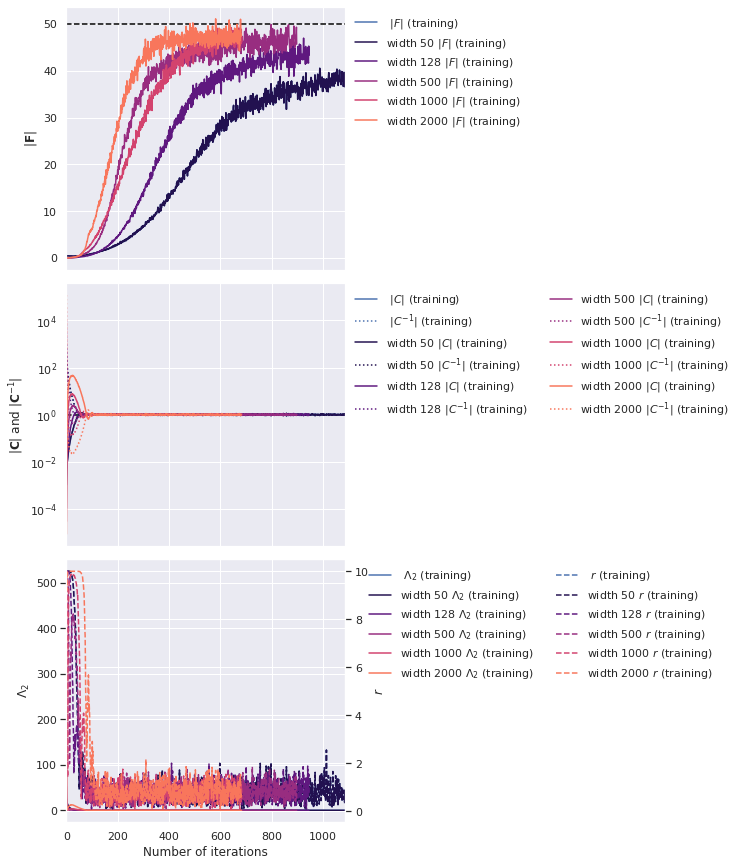

In [ ]:
import seaborn as sns
pal = sns.color_palette("magma")
colors = pal.as_hex() + ["blue", "orange", "purple"]
ax = IMNNs[0].plot(expected_detF=50)
for i,w in enumerate(widths[:]):
  IMNNs[i].plot(ax=ax, colour=colors[i], label="width %d"%(w))
# ax[0].set_yscale("log")

In [ ]:
for i in IMNNs:
  print(np.linalg.det(i.F))

39.84668
43.196552
42.924706
46.55634
47.65854


In [ ]:
widths =[50, 128, 500, 1000]
L = 2

act = stax.Selu

models = [build_model(L, w, act) for w in widths]
opts = [optimizers.adam(step_size=1e-3) for l in range(len(widths))]
model_keys = jax.random.split(rng, num=len(widths))

IMNNs = [imnn.SimulatorIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
    input_shape=input_shape, θ_fid=θ_fid, model=models[w],
    optimiser=opts[w], key_or_state=model_keys[w],
    simulator=simulator) for w in range(len(widths))
]

fit_keys = jax.random.split(rng, num=len(widths))
for i,w in enumerate(widths):
  print("fitting softplus imnn with nn width %d"%(w))
  IMNNs[i].fit(λ, ϵ, rng=fit_keys[i], print_rate=None, best=True, patience=100)

fitting softplus imnn with nn width 50
fitting softplus imnn with nn width 128
fitting softplus imnn with nn width 500
fitting softplus imnn with nn width 1000


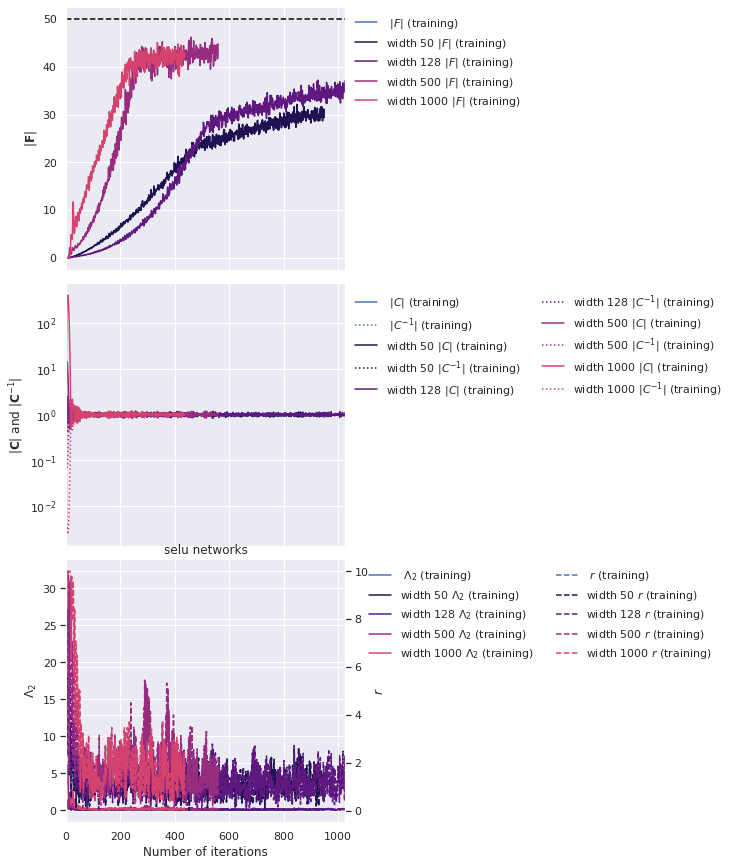

In [ ]:
ax = IMNNs[0].plot(expected_detF=50)
for i,w in enumerate(widths[:]):
  IMNNs[i].plot(ax=ax, colour=colors[i], label="width %d"%(w))

plt.title('selu networks')
plt.show()